# Notebook for data processing and simple visualization

In [21]:
from scraper import KinoPoisk
import pandas as pd
import numpy as np
from currency_converter import CurrencyConverter
import sqlite3
from datetime import date
import sys
from IPython.display import clear_output
import seaborn as sns
import matplotlib.pyplot as plt

## Raw Data

In [6]:
df = pd.read_csv('KinoPoisk.csv')
df.head(5)

,Аудиодорожки,Субтитры,Качество видео,Год производства,Страна,Жанр,Слоган,Режиссер,Сценарий,Продюсер,...,Название фильма,Актеры,Оценка фильма,Релиз на Blu-ray,Сборы в России,Ре-релиз (РФ),Цифровой релиз,Директор фильма,4K доступно только на больших экранах,Платформа
0,"Русский, Английский",Русские,NaN,1999,США,"драма, фэнтези, криминал",«Пол Эджкомб не верил в чудеса. Пока не столкн...,Фрэнк Дарабонт,"Фрэнк Дарабонт, Стивен Кинг","Фрэнк Дарабонт, Дэвид Валдес",...,Зеленая миля (1999)The Green Mile16+,Том ХэнксДэвид МорсБонни ХантМайкл Кларк Дунка...,9.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"Русский, Английский",Русские,NaN,1993,США,"драма, биография, история, военный",«Этот список - жизнь»,Стивен Спилберг,"Стивен Зеллиан, Томас Кенилли","Ирвинг Гловин, Кэтлин Кеннеди, Бранко Лустиг, ...",...,Список Шиндлера (1993)Schindler's List16+,Лиам НисонБен КингслиРэйф ФайнсКэролайн Гудолл...,8.8,"11 апреля 2013, «Двадцатый Век Фокс СНГ»",NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,1994,США,драма,«Страх - это кандалы. Надежда - это свобода»,Фрэнк Дарабонт,"Фрэнк Дарабонт, Стивен Кинг","Лиз Глоцер, Дэвид В. Лестер, Ники Марвин",...,Побег из Шоушенка (1994)The Shawshank Redempti...,Тим РоббинсМорган ФриманБоб ГантонУильям Сэдле...,9.1,"27 августа 2009, «Союз-Видео»",$87 432,NaN,NaN,NaN,NaN,NaN
3,"Русский, Русский 5.1, Английский, Английский 5.1",Русские,NaN,1994,США,"драма, комедия, мелодрама, история, военный","«Мир уже никогда не будет прежним, после того ...",Роберт Земекис,"Эрик Рот, Уинстон Грум","Венди Файнерман, Стив Старки, Стив Тиш, ...",...,Форрест Гамп (1994)Forrest Gump16+,Том ХэнксРобин РайтСалли ФилдГэри СинизМайкелт...,8.9,NaN,$84 460,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,2003,"Новая Зеландия, США","фэнтези, приключения, драма",«There can be no triumph without loss. No vict...,Питер Джексон,"Фрэн Уолш, Филиппа Бойенс, Питер Джексон, ...","Питер Джексон, Eric Monette, Барри М. Осборн, ...",...,Властелин колец: Возвращение короля (2003)The ...,Элайджа ВудВигго МортенсенШон ЭстинИэн Маккелл...,8.7,"6 апреля 2010, «Юниверсал Пикчерс Рус»",$14 085 000,"29 апреля 2021, «UPI»",NaN,NaN,NaN,NaN


## Part 1: Data proccessing

### Deleting too small columns

In [22]:
df_cleared = df.dropna(axis=1, thresh=190)
df_cleared.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Аудиодорожки      209 non-null    object 
 1   Субтитры          209 non-null    object 
 2   Год производства  250 non-null    int64  
 3   Страна            250 non-null    object 
 4   Жанр              250 non-null    object 
 5   Слоган            250 non-null    object 
 6   Режиссер          250 non-null    object 
 7   Сценарий          250 non-null    object 
 8   Продюсер          205 non-null    object 
 9   Оператор          215 non-null    object 
 10  Композитор        250 non-null    object 
 11  Художник          248 non-null    object 
 12  Монтаж            247 non-null    object 
 13  Бюджет            198 non-null    object 
 14  Сборы в США       190 non-null    object 
 15  Сборы в мире      197 non-null    object 
 16  Зрители           215 non-null    object 
 1

### Transforming data

In [23]:
df_cleared['Бюджет'] = df_cleared['Бюджет'].str.replace(' ', '')
df_cleared['Бюджет'] = df_cleared['Бюджет'].str.replace('$', '')
c = CurrencyConverter()

def budget_transformation_to_usd(x):
    try:
        result = 0
        year = df_cleared.loc[df_cleared['Бюджет'] == x, 'Год производства'].values[0]
        if type(x) == str:
            if '€' in x:
                x = float(x.replace('€', ''))
                x = (c.convert(x, 'EUR', 'USD', date=date(year, 1, 1)))
            elif 'DEM' in x:
                x = float(x.replace('DEM', ''))
                x = (c.convert(x, 'DEM', 'USD', date=date(year, 1, 1)))
            elif 'р.' in x:
                x = float(x.replace('р.', ''))
                x = (c.convert(x, 'RUB', 'USD', date=date(year, 1, 1)))
            elif '₽' in x:
                x = float(x.replace('₽', ''))
                x = (c.convert(x, 'RUB', 'USD', date=date(year, 1, 1)))
            elif '£' in x:
                x = float(x.replace('£', ''))
                x = (c.convert(x, 'GBP', 'USD', date=date(year, 1, 1)))
            elif 'FRF' in x:
                x = float(x.replace('FRF', ''))
                x = (c.convert(x, 'FRF', 'USD', date=date(year, 1, 1)))
            elif '¥' in x:
                x = float(x.replace('¥', ''))
                x = (c.convert(x, 'JPY', 'USD', date=date(year, 1, 1)))
            elif 'DKK' in x:
                x = float(x.replace('DKK', ''))
                x = (c.convert(x, 'DKK', 'USD', date=date(year, 1, 1)))
        elif type(x) != str:
            x = str(x)
            if '€' in x:
                x = float(x.replace('€', ''))
                x = (c.convert(x, 'EUR', 'USD', date=date(year, 1, 1)))
            elif 'DEM' in x:
                x = float(x.replace('DEM', ''))
                x = (c.convert(x, 'DEM', 'USD', date=date(year, 1, 1)))
            elif 'р.' in x:
                x = float(x.replace('р.', ''))
                x = (c.convert(x, 'RUB', 'USD', date=date(year, 1, 1)))
            elif '₽' in x:
                x = float(x.replace('₽', ''))
                x = (c.convert(x, 'RUB', 'USD', date=date(year, 1, 1)))
            elif '£' in x:
                x = float(x.replace('£', ''))
                x = (c.convert(x, 'GBP', 'USD', date=date(year, 1, 1)))
            elif 'FRF' in x:
                x = float(x.replace('FRF', ''))
                x = (c.convert(x, 'FRF', 'USD', date=date(year, 1, 1)))
            elif '¥' in x:
                x = float(x.replace('¥', ''))
                x = (c.convert(x, 'JPY', 'USD', date=date(year, 1, 1)))
            elif 'DKK' in x:
                x = float(x.replace('DKK', ''))
                x = (c.convert(x, 'DKK', 'USD', date=date(year, 1, 1)))
        return x
    except:
        return x
            
df_cleared['Бюджет'] = df_cleared['Бюджет'].apply(lambda y: budget_transformation_to_usd(x=y))
df_cleared['Бюджет'] = df_cleared['Бюджет'].str.replace('nan', '0')
df_cleared['Бюджет'] = df_cleared['Бюджет'].apply(pd.to_numeric)

clear_output()

In [24]:
df_cleared['Сборы в США'] = df_cleared['Сборы в США'].str.replace(' ', '')
df_cleared['Сборы в США'] = df_cleared['Сборы в США'].str.replace('$', '')

df_cleared['Сборы в США'] = df_cleared['Сборы в США'].str.replace('nan', '0')
df_cleared['Сборы в США'] = df_cleared['Сборы в США'].apply(pd.to_numeric)

clear_output()

In [25]:
df_cleared['Сборы в мире'] = df_cleared['Сборы в мире'].str.replace(' ', '')
df_cleared['Сборы в мире'] = df_cleared['Сборы в мире'].str.replace('$', '')
df_cleared['Сборы в мире'] = df_cleared['Сборы в мире'].str.replace('+', '')
df_cleared['Сборы в мире'] = df_cleared['Сборы в мире'].apply(lambda x: max(x.split('=')) if type(x) == str else x)
df_cleared['Сборы в мире'] = df_cleared['Сборы в мире'].str.replace('nan', '0')
df_cleared['Сборы в мире'] = df_cleared['Сборы в мире'].apply(pd.to_numeric)
clear_output()


In [26]:
def views(x):
    list_of_symbols = [' ', 'млн.', 'тыс.', 'млн', 'тыс', 'nan']
    list_of_replacements = ['', '000000', '000', '000000', '000', '0']
    if type(x) != str:
        x = str(x)
    for symbol in list_of_symbols:
        if symbol in x:
            x = x.replace(symbol, list_of_replacements[list_of_symbols.index(symbol)])
    if '.' in x:
        x = x.replace('.', '')
        x = float(x) * (0.1)
        return int(x)
    else:
        return int(x)
df_cleared['Зрители'] = df_cleared['Зрители'].apply(views)
clear_output()

In [27]:
pd.options.display.float_format = "{:.2f}".format
df_cleared.describe()

,Год производства,Бюджет,Сборы в США,Сборы в мире,Зрители,Оценка фильма
count,250.00,181.00,190.00,197.00,250.00,250.00
mean,1997.19,74781511.76,156904976.49,362520773.62,24716632.80,8.22
std,16.42,72229742.82,151522536.53,428477578.07,27006766.81,0.25
min,1939.00,340000.00,5710.00,1887.00,0.00,7.70
25%,1987.25,20000000.00,45350035.25,57759104.00,1500000.00,8.00
50%,2001.00,50000000.00,119495360.50,264118201.00,16150000.00,8.20
75%,2010.00,102000000.00,231176147.50,516950043.00,41500000.00,8.40
max,2021.00,356000000.00,858373000.00,2923905528.00,178100000.00,9.10


In [28]:
def categorical_data_processing(column):
    all_categories = []
    for record in df_cleared[column]:
        new_record = record.split(',')
        for word in new_record:
            word = word.strip()
        all_categories.append(word)
    all_categories = list(set(all_categories))
    for category in all_categories:
        df_cleared[column + ': ' + category] = df_cleared[column].apply(lambda x: True if category in x else False)

categorical_data_processing(column='Жанр')
categorical_data_processing(column='Страна')
clear_output()



In [240]:
'''conn = sqlite3.connect('KinoPoisk.db')
c = conn.cursor()
for row in c.execute('SELECT * FROM films_data'):
    print(row)
conn.commit()
conn.close()'''

"conn = sqlite3.connect('KinoPoisk.db')\nc = conn.cursor()\nfor row in c.execute('SELECT * FROM films_data'):\n    print(row)\nconn.commit()\nconn.close()"

## Part 2: Visualization

### Histograms

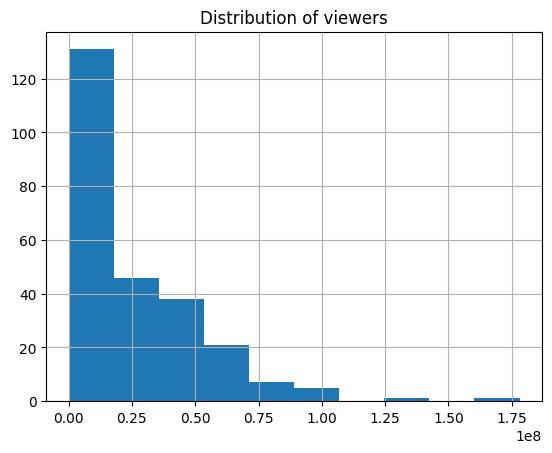

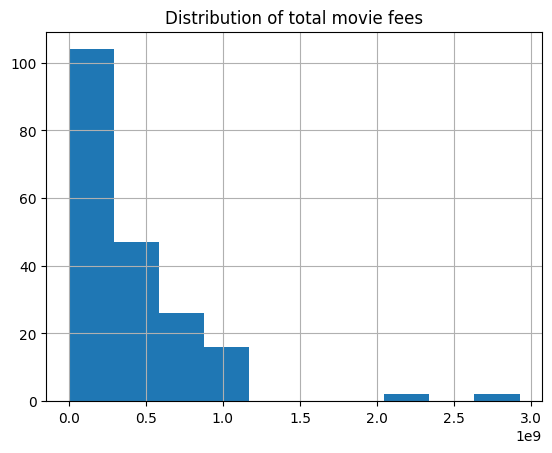

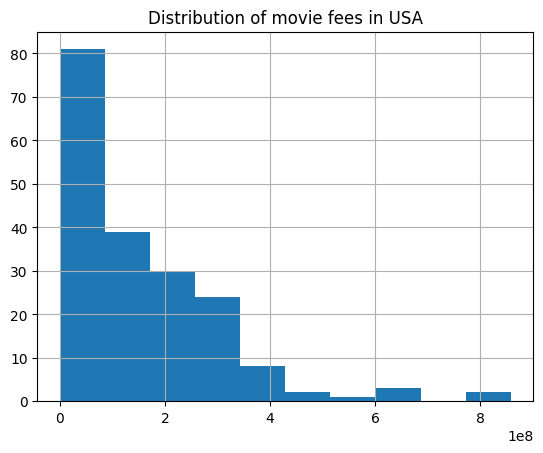

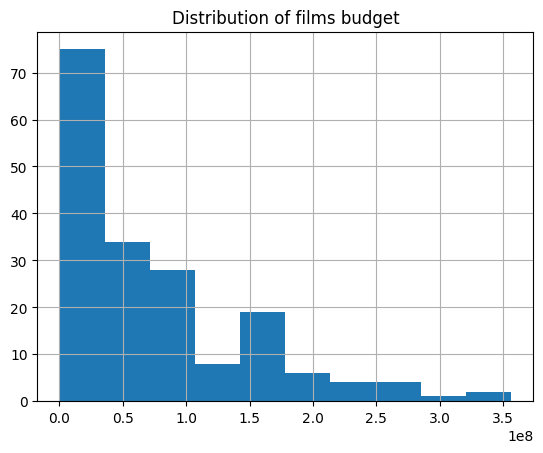

In [29]:
df_cleared['Зрители'].hist()
plt.title('Distribution of viewers')
plt.show()
df_cleared['Сборы в мире'].hist()
plt.title('Distribution of total movie fees')
plt.show()
df_cleared['Сборы в США'].hist()
plt.title('Distribution of movie fees in USA')
plt.show()
df_cleared['Бюджет'].hist()
plt.title('Distribution of films budget')
plt.show()

### Countplots

In [15]:
df_cleared.describe()

,Год производства,Бюджет,Сборы в США,Сборы в мире,Зрители,Оценка фильма
count,250.00,181.00,190.00,197.00,250.00,250.00
mean,1997.19,74781511.76,156904976.49,362520773.62,24716632.80,8.22
std,16.42,72229742.82,151522536.53,428477578.07,27006766.81,0.25
min,1939.00,340000.00,5710.00,1887.00,0.00,7.70
25%,1987.25,20000000.00,45350035.25,57759104.00,1500000.00,8.00
50%,2001.00,50000000.00,119495360.50,264118201.00,16150000.00,8.20
75%,2010.00,102000000.00,231176147.50,516950043.00,41500000.00,8.40
max,2021.00,356000000.00,858373000.00,2923905528.00,178100000.00,9.10


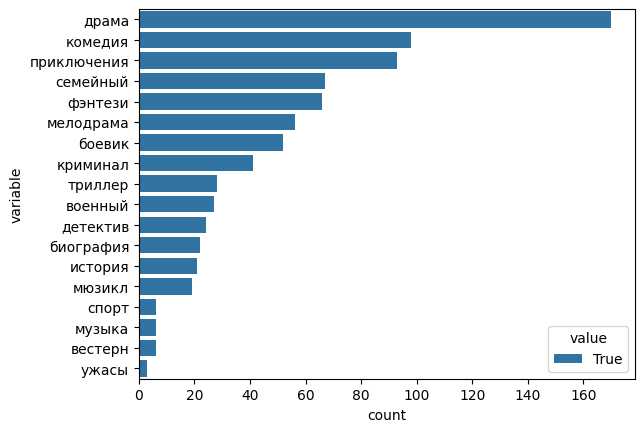

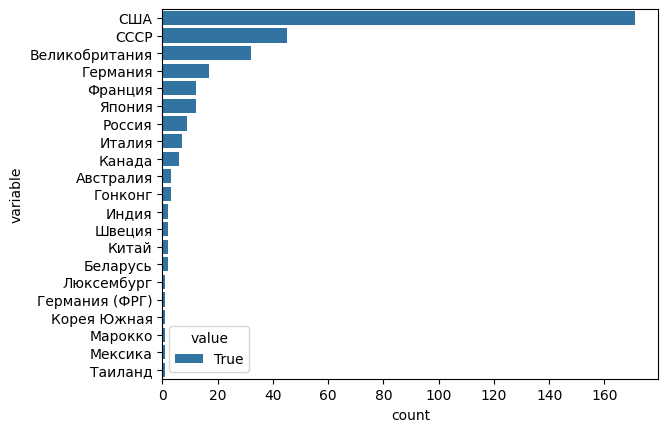

In [45]:
filter_cols_genre = [col for col in df_cleared.columns if col.startswith('Жанр: ')]
data_genre = pd.melt(df_cleared, value_vars=filter_cols_genre)
data_genre['variable'] = data_genre['variable'].apply(lambda x: x.replace('Жанр: ', ''))
sns.countplot(y="variable", hue="value", data=data_genre[data_genre.values == True], order = data_genre[data_genre.values == True]['variable'].value_counts().index)
plt.show()

filter_cols_country = [col for col in df_cleared.columns if col.startswith('Страна: ')]
data_country = pd.melt(df_cleared, value_vars=filter_cols_country)
data_country['variable'] = data_country['variable'].apply(lambda x: x.replace('Страна: ', ''))
sns.countplot(y="variable", hue="value", data=data_country[data_country.values == True], order = data_country[data_country.values == True]['variable'].value_counts().index)
plt.show()


### Time-series plots

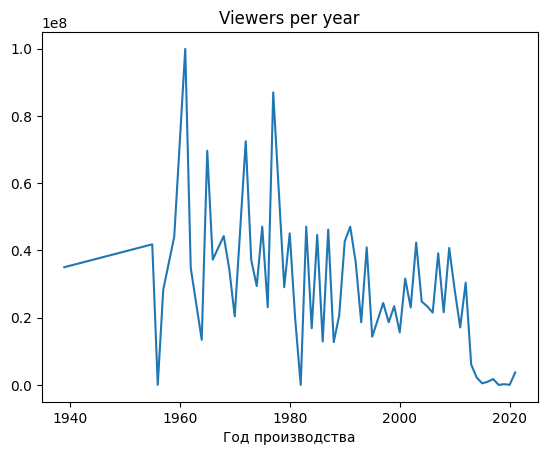

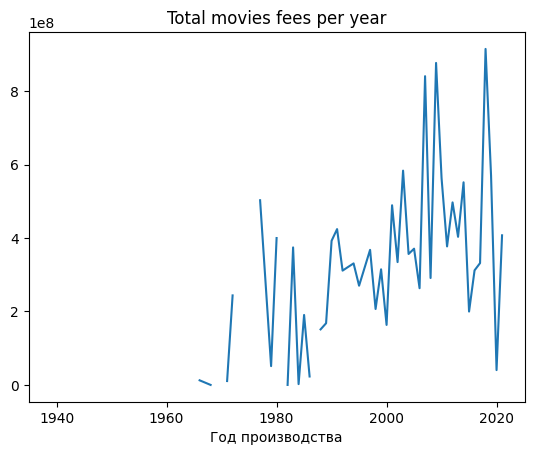

In [18]:
viewers_per_year = df_cleared.groupby('Год производства')['Зрители'].mean()
viewers_per_year.plot()
plt.title('Viewers per year')
plt.show()

total_fees_per_year = df_cleared.groupby('Год производства')['Сборы в мире'].mean()
total_fees_per_year.plot()
plt.title('Total movies fees per year')
plt.show()